**Image classification**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

from google.colab import drive
drive.mount('/content/gdrive')

data_dir = 'gdrive/My Drive/vehicles_images'
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()


Mounted at /content/gdrive
Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.
['bus', 'motorcycle', 'plane', 'train']
0.0 1.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (Non

**Training the model**

In [2]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)


Epoch 1/10
108/108 [==============================] - 158s 1s/step - loss: 1.2114 - accuracy: 0.4619 - val_loss: 1.0509 - val_accuracy: 0.5724
Epoch 2/10
108/108 [==============================] - 109s 1s/step - loss: 1.0135 - accuracy: 0.5771 - val_loss: 0.9677 - val_accuracy: 0.5933
Epoch 3/10
108/108 [==============================] - 110s 1s/step - loss: 0.8840 - accuracy: 0.6512 - val_loss: 0.9664 - val_accuracy: 0.6083
Epoch 4/10
108/108 [==============================] - 110s 1s/step - loss: 0.7595 - accuracy: 0.7109 - val_loss: 1.0435 - val_accuracy: 0.5713
Epoch 5/10
108/108 [==============================] - 109s 1s/step - loss: 0.6182 - accuracy: 0.7644 - val_loss: 1.0415 - val_accuracy: 0.6118
Epoch 6/10
108/108 [==============================] - 110s 1s/step - loss: 0.4616 - accuracy: 0.8313 - val_loss: 1.0592 - val_accuracy: 0.5921
Epoch 7/10
108/108 [==============================] - 109s 1s/step - loss: 0.3119 - accuracy: 0.8955 - val_loss: 1.3264 - val_accuracy: 0.5852

**Graphical plot of training and validation accuracy**

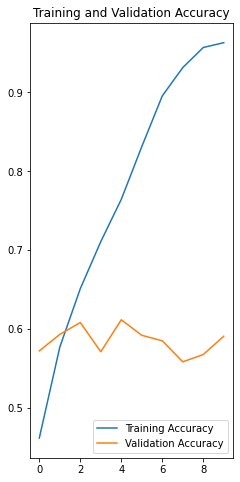

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Accuracy')

plt.show()

**Recognising the four object types in the dataset**

(32, 180, 180, 3)
(32,)


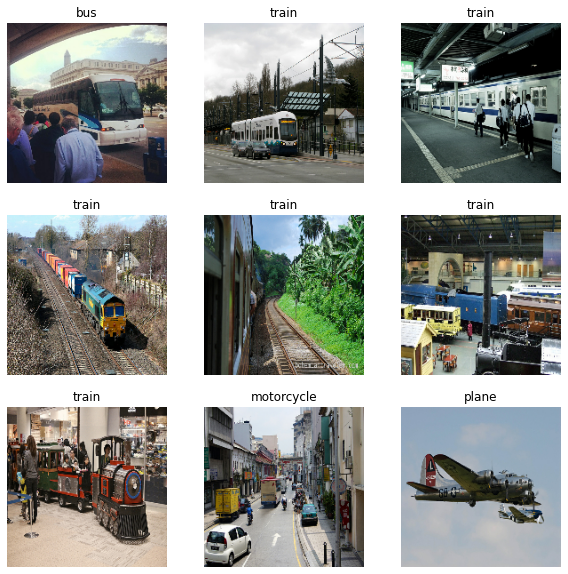

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

**Testing the trained model**

In [5]:
# import required module

import os
# assign directory
from google.colab import drive
drive.mount('/content/gdrive')
directory = 'gdrive/My Drive/random-vehicles'
img_height = 180
img_width = 180 

for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  img = keras.preprocessing.image.load_img(
      f, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      filename + " " + "most likely belongs to {} with a {:.2f}% confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

  # print('predictions',predictions)
  # print(
  #     "This image is %.2f percent motorcycle, This image is %.2f percent bus, This image is %.2f percent train and %.2f percent plane."
  #     % (100 * (1 - score), 100 * score)
  # )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
near-aero2.jpg most likely belongs to bus with a 96.29% confidence.
near-aero.png most likely belongs to bus with a 62.93% confidence.
far-aero.jpg most likely belongs to plane with a 99.96% confidence.
aero.PNG most likely belongs to train with a 88.08% confidence.
train-near1.PNG most likely belongs to train with a 71.01% confidence.
train-busy.PNG most likely belongs to train with a 95.12% confidence.
train-close.PNG most likely belongs to plane with a 94.45% confidence.
train-near2.PNG most likely belongs to train with a 64.16% confidence.
far-bus1.PNG most likely belongs to plane with a 55.29% confidence.
bus-busy.PNG most likely belongs to motorcycle with a 36.38% confidence.
bus-near.PNG most likely belongs to plane with a 84.64% confidence.
bus-busy2.PNG most likely belongs to train with a 89.48% confidence.
motorcycle-close.PNG most likely belongs 

**Fine-tuning**

In [6]:
IMG_SIZE = (180, 180)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


base_model.trainable = True
base_model.summary()

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


108/108 [==============================] - 122s 1s/step - loss: 0.0793 - accuracy: 0.9774 - val_loss: 1.6815 - val_accuracy: 0.5956
Epoch 11/20
108/108 [==============================] - 111s 1s/step - loss: 0.0742 - accuracy: 0.9777 - val_loss: 1.7191 - val_accuracy: 0.5956
Epoch 12/20
108/108 [==============================] - 111s 1s/step - loss: 0.0712 - accuracy: 0.9786 - val_loss: 1.7460 - val_accuracy: 0.5979
Epoch 13/20
108/108 [==============================] - 110s 1s/step - loss: 0.0689 - accuracy: 0.9783 - val_loss: 1.7687 - val_accuracy: 0.6037
Epoch 14/20
108/108 [==============================] - 110s 1s/step - loss: 0.0671 - accuracy: 0.9780 - val_loss: 1.7879 - val_accuracy: 0.6014
Epoch 15/20
108/108 [==============================] - 110s 1s/step - loss: 0.0654 - accuracy: 0.9786 - val_loss: 1.8087 - val_accuracy: 0.6002
Epoch 16/20
108/108 [==============================] - 111s 1s/step - loss: 0.0639 - accuracy: 0.9783 - val_loss: 1.8279 - val_accuracy: 0.6002
Epoc

**Making second prediction**

In [7]:
import os
# assign directory
from google.colab import drive
drive.mount('/content/gdrive')
directory = 'gdrive/My Drive/random-vehicles'
img_height = 180
img_width = 180 

for filename in os.listdir(directory):
  f2 = os.path.join(directory, filename)
  img2 = keras.preprocessing.image.load_img(
      f2, target_size=(img_height, img_width)
  )
  img_array2 = keras.preprocessing.image.img_to_array(img2)
  img_array2 = tf.expand_dims(img_array2, 0)  # Create batch axis

  predictions2 = model.predict(img_array2)
  score2 = tf.nn.softmax(predictions2[0])

  print(
      filename + " " + "most likely belongs to {} with a {:.2f}% confidence."
      .format(class_names[np.argmax(score2)], 100 * np.max(score2))
  )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
near-aero2.jpg most likely belongs to bus with a 99.13% confidence.
near-aero.png most likely belongs to bus with a 76.84% confidence.
far-aero.jpg most likely belongs to plane with a 100.00% confidence.
aero.PNG most likely belongs to train with a 79.73% confidence.
train-near1.PNG most likely belongs to train with a 76.36% confidence.
train-busy.PNG most likely belongs to train with a 96.54% confidence.
train-close.PNG most likely belongs to plane with a 97.85% confidence.
train-near2.PNG most likely belongs to train with a 66.75% confidence.
far-bus1.PNG most likely belongs to plane with a 70.75% confidence.
bus-busy.PNG most likely belongs to motorcycle with a 57.67% confidence.
bus-near.PNG most likely belongs to plane with a 75.32% confidence.
bus-busy2.PNG most likely belongs to train with a 81.97% confidence.
motorcycle-close.PNG most likely belongs